In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

sys.path.append('../')
sys.path.append('../Lib')
sys.path.append('../Models')
sys.path.append('../Protocols')
from cell_models import kernik, protocols, paci_2018

import mod_protocols
import protocol_lib
import mod_kernik as kernik
import mod_trace as trace
from Models.br1977 import BR1977
from ord2011 import ORD2011
import model_response

In [13]:
trial_conditions = "Leem-v1"
prestep = 5000
window = 10
step_size = 5
holding_step = 500
only_end = False
with_artefact =False
model_name = 'ORD2011'

# path_to_data = f"ga_results/{trial_conditions}"
# files = os.listdir(path_to_data)
# for f in files:
#     if ('pkl' in f) and (f'p{prestep}' in f) and (f'h{holding_step}' in f) and (f'oe{only_end}' in f):
#         file_name = f
# print(file_name)
# final_protocol = pickle.load(open(f"{path_to_data}/{file_name}", 'rb'))
# # print("="*50)
# # print(final_protocol)
# # print("="*50)
# print(f'The protocol is {final_protocol.get_voltage_change_endpoints()[-1]} ms')

# # times = np.arange(0, short_protocol.get_voltage_change_endpoints()[-1], 1)         
# # print(times.shape)
# # short_protocol.plot_voltage_clamp_protocol(times)    

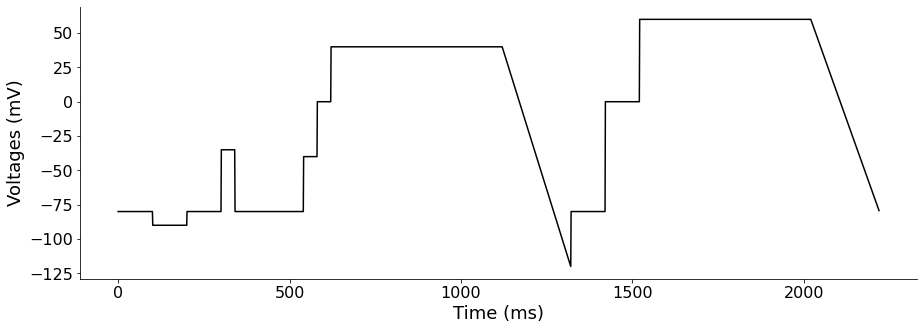

In [7]:
final_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps

final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
final_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
final_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=200) )
final_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
final_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )  # <- why?? vo
final_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
final_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=200)) # ramp step
final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
final_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=100) )
final_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=500) )
final_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=60, voltage_end=-80, duration=200)) # ramp step

times = np.arange(0, final_protocol.get_voltage_change_endpoints()[-1], 1) 
final_protocol.plot_voltage_clamp_protocol(times)

In [8]:
start_time = time.time()

currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_CaL', 'I_K1', 'I_NaL' ]               
tr = None
if model_name=='ORD2011' :
    model = ORD2011(final_protocol)
    tr = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='OHara2017':
    model = '../mmt-model-files/ohara-cipa-v1-2017_VC.mmt'
    tr = model_response.get_model_response_with_myokit(model, final_protocol, prestep=prestep)
elif model_name=='BR1977' :
    currents = ['I_Na', 'I_si', 'I_K1', 'I_x1']
    model = BR1977(final_protocol)  
    tr = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='Kernik':
    currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_F', 'I_CaL', 'I_K1'] 
    k = kernik.KernikModel(is_exp_artefact=True)        
    tr = k.generate_response(final_protocol, is_no_ion_selective=False)

print("--- %s seconds ---"%(time.time()-start_time))

--- 4.636185646057129 seconds ---


In [9]:
start_time = time.time()
current_contributions = tr.current_response_info.get_current_contributions( time=tr.t, window=window, step_size=step_size)
total_current = tr.current_response_info.get_current_summed()
c_li = {}
for current_name in currents:
    c = []
    for t in tr.t:    
        idx = current_contributions['Time Mid'].sub(t).abs().idxmin()
        c.append(current_contributions[current_name].loc[idx])        
    c_li[current_name] = c
print("--- %s seconds ---"%(time.time()-start_time))

--- 8.682921171188354 seconds ---


In [10]:
current_contributions

,Time Start,Time End,Time Mid,I_Na,I_NaL,I_To,I_CaL,I_CaNa,I_CaK,I_Kr,I_Ks,I_K1,I_NaCa,I_NaCa_ss,I_NaK,I_Kb,I_Nab,I_Cab,I_pCa
0,0,10,5.0,0.007239,0.000153,0.001001,0.000001,6.950952e-08,2.625048e-10,0.000006,3.108973e-09,0.876576,0.007442,0.001798,0.074111,0.000076,0.014909,0.016641,0.000046
1,5,15,10.0,0.007239,0.000153,0.001001,0.000001,6.951009e-08,2.625049e-10,0.000006,3.110030e-09,0.876577,0.007442,0.001798,0.074110,0.000076,0.014909,0.016641,0.000046
2,10,20,15.0,0.007239,0.000153,0.001001,0.000001,6.951053e-08,2.625049e-10,0.000006,3.110859e-09,0.876578,0.007442,0.001798,0.074109,0.000076,0.014909,0.016641,0.000046
3,15,25,20.0,0.007239,0.000153,0.001001,0.000001,6.951098e-08,2.625049e-10,0.000006,3.111686e-09,0.876579,0.007442,0.001798,0.074108,0.000076,0.014909,0.016642,0.000046
4,20,30,25.0,0.007239,0.000153,0.001001,0.000001,6.951142e-08,2.625049e-10,0.000006,3.112512e-09,0.876580,0.007442,0.001798,0.074107,0.000076,0.014909,0.016642,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,2190,2200,2195.0,0.001787,0.000099,0.006220,0.000040,2.318169e-06,4.399062e-08,0.438381,2.935689e-02,0.397949,0.032228,0.016032,0.059002,0.000479,0.008865,0.009491,0.000067
439,2195,2205,2200.0,0.001990,0.000056,0.004435,0.000019,1.092204e-06,1.671177e-08,0.373552,2.038551e-02,0.477568,0.031230,0.014539,0.056877,0.000338,0.009099,0.009843,0.000065
440,2200,2210,2205.0,0.002115,0.000033,0.003024,0.000009,5.058993e-07,6.102767e-09,0.308636,1.280065e-02,0.555069,0.030281,0.013261,0.054922,0.000233,0.009348,0.010205,0.000064
441,2205,2215,2210.0,0.002134,0.000020,0.001988,0.000004,2.340972e-07,2.155099e-09,0.247714,6.630184e-03,0.624764,0.029808,0.012340,0.053891,0.000156,0.009752,0.010734,0.000064


In [11]:
max_contributions = tr.current_response_info.get_max_current_contributions(tr.t, window=window, step_size=step_size)
max_contributions

,Current,Contribution,Time Start,Time End
0,I_Na,0.653387,300.0,310.0
1,I_NaL,0.261818,320.0,330.0
2,I_To,0.278810,625.0,635.0
3,I_CaL,0.781388,585.0,595.0
4,I_CaNa,0.080314,585.0,595.0
5,I_CaK,0.128978,620.0,630.0
6,I_Kr,0.721510,1205.0,1215.0
7,I_Ks,0.441709,2010.0,2020.0
8,I_K1,0.966037,1310.0,1320.0
9,I_NaCa,0.135706,1520.0,1530.0


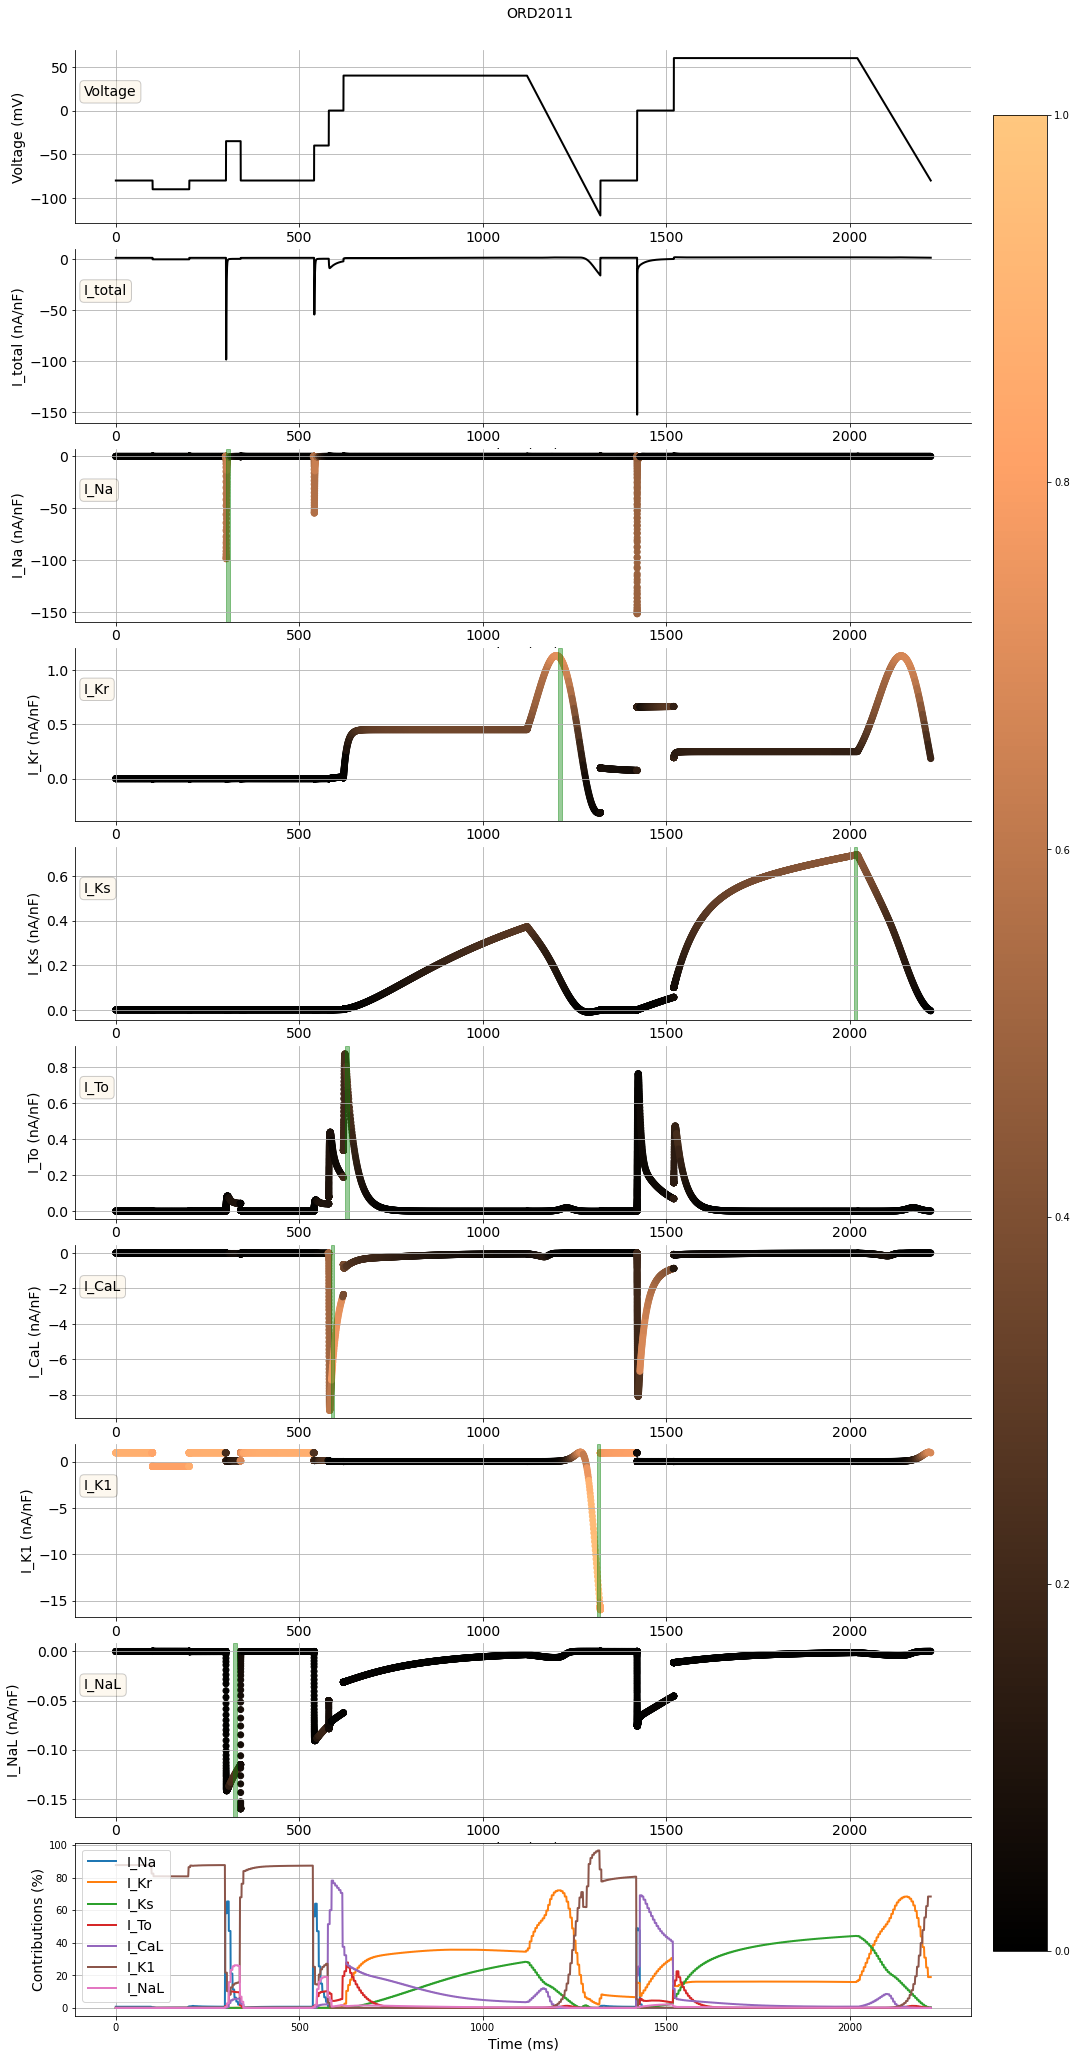

In [19]:
'''
Plot
'''
fig, ax = plt.subplots(len(currents)+3,1, figsize=(15,30))    
fig.suptitle(model_name, fontsize=14)
total_duration = holding_step
for i, name in enumerate(['Voltage', 'I_total' ] + currents):        
#     ax[i].set_title(name)
    # ax[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax[i].set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)', fontsize=14)           
    ax[i].tick_params(axis="x", labelsize=14)
    ax[i].tick_params(axis="y", labelsize=14)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)     
    ax[i].text(0.01, 0.8, name, transform=ax[i].transAxes, fontsize=14, verticalalignment='top', c='k',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))    
    if i==0:
        ax[i].set_ylabel(f'{name} (mV)', fontsize=14)     
        ax[i].plot( tr.t, final_protocol.get_voltage_clamp_protocol(tr.t), label=name, color='k', linewidth=2)    
    elif i==1:
        ax[i].set_ylabel(f'{name} (nA/nF)', fontsize=14)     
        ax[i].plot( tr.t, tr.current_response_info.get_current_summed(), label=name, color='k', linewidth=2)           
    else:         
        ax[i].set_ylabel(f'{name} (nA/nF)', fontsize=14) 
        ax_im = ax[i].scatter(tr.t, tr.current_response_info.get_current([name]), c=c_li[name], cmap=cm.copper, vmin=0, vmax=1, label=[name, name])                
        # short_protocol = pickle.load(open(f"{path_to_data}/short_{name}_p{prestep}_oe{only_end}_a{with_artefact}.pkl", 'rb'))                             
        # for j in range(len(currents)+3):                      
        #     ax[j].axvspan(total_duration, total_duration+short_protocol.get_voltage_change_endpoints()[-1], color='b' if i==j else 'k', alpha=.1)                        
#             ax[j].text(p, 0.8, name, transform=ax[j].transAxes, fontsize=14, verticalalignment='top', bbox=props, c='b')    
        # total_duration += short_protocol.get_voltage_change_endpoints()[-1]+holding_step
      
        contribution = max_contributions[max_contributions["Current"]==name]['Contribution'].values[0]
        start = max_contributions[max_contributions["Current"]==name]['Time Start'].values[0]
        end = max_contributions[max_contributions["Current"]==name]['Time End'].values[0]         
        ax[i].axvspan(start, end, color='g', alpha=0.4)   
        
        ax[len(currents)+2].plot( tr.t, np.array(c_li[name])*100, label=name, linewidth=2)  
#         ax[i].text(0.01, 0.8, name, transform=ax[i].transAxes, fontsize=14, verticalalignment='top', c='k',
#                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))              
#     ax[i].legend(loc=2, prop={'size': 14})    
    ax[i].grid()
ax[len(currents)+2].set_xlabel('Time (ms)', fontsize=14)
ax[len(currents)+2].set_ylabel('Contributions (%)', fontsize=14)     
ax[len(currents)+2].legend(loc=2, prop={'size': 14})    
ax[len(currents)+2].grid()
# fig = plt.gcf()
cbar_ax = fig.add_axes([0.92, 0.08, 0.05, 0.85])
fig.colorbar(ax_im, cax=cbar_ax)
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.9, top=0.96, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig( f"ga_results/{trial_conditions}_p{prestep}.jpg", dpi=200)
plt.close(fig)

In [8]:
# print("Complete")